In [1]:
!pip install  -q 'ibis-framework[mssql,pyspark,duckdb,deltalake]'
%pip install  -q altair

StatementMeta(, 6da2ef83-e0ae-4a3c-89b2-6b2f7d1c237f, 8, Finished, Available, Finished)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 2.0.0 requires sentencepiece, which is not installed.
sentence-transformers 2.0.0 requires torchvision, which is not installed.
dash 2.14.0 requires Flask<2.3.0,>=1.0.4, but you have flask 3.0.0 which is incompatible.
dash 2.14.0 requires Werkzeug<2.3.0, but you have werkzeug 3.0.1 which is incompatible.
tensorflow 2.12.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



In [20]:
#switch between duckdb,pyspark and mssql , spark sql require the lakehouse to be attached
workspace = 'sqlengines'
lakehouse = 'NYT'
engine    = "duckdb"

StatementMeta(, 6da2ef83-e0ae-4a3c-89b2-6b2f7d1c237f, 28, Finished, Available, Finished)

**_<u><mark>Get connection</mark></u>_**

In [21]:
import ibis, sqlglot
from ibis.expr.visualize import to_graph
def get_ibis_connection(workspace ,lakehouse ,engine):
    import ibis
    import sempy.fabric as fabric
    workspaceID = fabric.resolve_workspace_id(workspace)
    data = notebookutils.lakehouse.getWithProperties(name= lakehouse, workspaceId=workspaceID)
    lakehouseID = data['id']
    if engine =='mssql':
        import struct , pyodbc , ibis.backends.mssql
        dwh_backend = ibis.backends.mssql.Backend()
        sql_endpoint = data['properties']['sqlEndpointProperties']['connectionString']
        token = notebookutils.credentials.getToken('https://analysis.windows.net/powerbi/api').encode("UTF-16-LE")
        token_struct = struct.pack(f'<I{len(token)}s', len(token), token)
        dwh_backend.con = pyodbc.connect(f"Driver={{ODBC Driver 18 for SQL Server}};Server={sql_endpoint},1433;Encrypt=Yes;TrustServerCertificate=No", attrs_before={1256: token_struct})
        dwh_backend.raw_sql(f" use {lakehouse};")
        return dwh_backend
    elif engine =='pyspark':
        return ibis.pyspark.connect()
    else:
        access_token     = notebookutils.credentials.getToken('storage')
        storage_options  = {"bearer_token": access_token, "use_fabric_endpoint": "true"} 
        con = getattr(ibis, engine).connect()
        base_path = f'abfss://{workspaceID}@onelake.dfs.fabric.microsoft.com/{lakehouseID}/Tables'
        list_db = [item.name for item in  notebookutils.fs.ls(base_path)]
        for db in list_db:
           con.create_database(db,force =False)
           for table in [item.name for item in  notebookutils.fs.ls(base_path +f'/{db}')]:
             t= con.read_delta(base_path+f'/{db}/{table}',table,storage_options = storage_options)
             con.create_view(table, t, database=f'{db}')      
        return con
def sql_to_df(query,engine,dialect):
    con = get_ibis_connection(workspace =workspace,lakehouse = lakehouse,engine = engine)
    if engine =='mssql':
       engine = 'tsql'
    standard_sql = sqlglot.transpile(query, read= dialect, write=engine)[0]
    if engine =='tsql':
        import pyarrow as pa
        cursor = con.raw_sql(standard_sql)
        columns = [column[0] for column in cursor.description]
        data = cursor.fetchall()
        columnar_data = list(zip(*data))
        arrow_table = pa.Table.from_arrays([pa.array(col) for col in columnar_data], columns)
        return arrow_table
    else:
       return  con.sql(standard_sql).to_pyarrow()

StatementMeta(, 6da2ef83-e0ae-4a3c-89b2-6b2f7d1c237f, 29, Finished, Available, Finished)

# SQL

In [22]:
sql = """ 
            SELECT  top 30
            date ,
            SUM(fare_amount) AS totalfares ,
            AVG(fare_amount) AS avgfares
            from ny.taxi 
            where year = 2024
            group by date
            order by date desc
      """
data = sql_to_df(sql,engine, dialect="mssql")

StatementMeta(, 6da2ef83-e0ae-4a3c-89b2-6b2f7d1c237f, 30, Finished, Available, Finished)

In [23]:
import altair as alt
brush = alt.selection_interval()
details = alt.Chart(data).mark_bar().encode(alt.X('date:T'),  alt.Y('totalfares:Q'), tooltip=[alt.Tooltip('date:T',format='%Y-%m-%d %H'),'totalfares:Q']
).properties( width=1400,  height=400 ).add_params( brush)

summary = alt.Chart(data).mark_square().encode( alt.X('date:T'), alt.Y('avgfares:Q'), tooltip=['avgfares:Q'] ).properties(  width=1400,  height=400).transform_filter( brush)
details & summary

StatementMeta(, 6da2ef83-e0ae-4a3c-89b2-6b2f7d1c237f, 31, Finished, Available, Finished)

alt.VConcatChart(...)

# Dataframe API

In [24]:
con = get_ibis_connection(workspace =workspace,lakehouse = lakehouse,engine = engine )

StatementMeta(, 6da2ef83-e0ae-4a3c-89b2-6b2f7d1c237f, 32, Finished, Available, Finished)

In [25]:
con.list_databases()

StatementMeta(, 6da2ef83-e0ae-4a3c-89b2-6b2f7d1c237f, 33, Finished, Available, Finished)

['dbo', 'information_schema', 'main', 'ny', 'pg_catalog']

In [26]:
taxi = con.table(name="taxi", database='ny')
agg = taxi.filter(taxi.year == 2024).group_by("date").aggregate(totalfares=taxi.fare_amount.sum(), avgfares=taxi.fare_amount.mean())
ibis.to_sql(agg)

StatementMeta(, 6da2ef83-e0ae-4a3c-89b2-6b2f7d1c237f, 34, Finished, Available, Finished)

```sql
SELECT
  "t1"."date",
  SUM("t1"."fare_amount") AS "totalfares",
  AVG("t1"."fare_amount") AS "avgfares"
FROM (
  SELECT
    *
  FROM "ny"."taxi" AS "t0"
  WHERE
    "t0"."year" = 2024
) AS "t1"
GROUP BY
  1
```

StatementMeta(, 6da2ef83-e0ae-4a3c-89b2-6b2f7d1c237f, 35, Finished, Available, Finished)

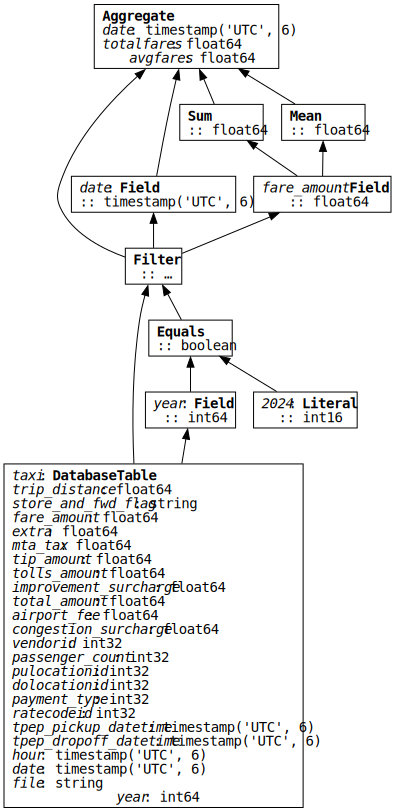

In [27]:
to_graph(agg)

In [28]:
import altair as alt
brush = alt.selection_interval()
details = alt.Chart(agg).mark_bar().encode(alt.X('date:T'),  alt.Y('totalfares:Q'), tooltip=[alt.Tooltip('date:T',format='%Y-%m-%d %H'),'totalfares:Q']
).properties( width=1400,  height=400 ).add_params( brush)

summary = alt.Chart(agg).mark_square().encode( alt.X('date:T'), alt.Y('avgfares:Q'), tooltip=['avgfares:Q'] ).properties(  width=1400,  height=400).transform_filter( brush)
details & summary

StatementMeta(, 6da2ef83-e0ae-4a3c-89b2-6b2f7d1c237f, 36, Finished, Available, Finished)

alt.VConcatChart(...)